In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns
import pickle
import copy

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot
import src.exp_utils as exp_utils
import experiments.efm as exp_efm
import experiments.kef as exp_kef
from experiments.rbm import parallel_optimize

# Outliers (level)

In [2]:
def rej_rate_outliers(outlier, n_ls, eps_ls, nreps, eps0, bandwidth=1., dim=1, alpha=0.05):
    res = {oo: {kk: {
        "tilted": {"stat": [], "pval": [], "rej": [], "boot_stats": []},
        "rbf": {"stat": [], "pval": [], "rej": [], "boot_stats": []},
        "tilted_ol_robust": {"nonsq_stat": [], "threshold": [], "rej": []},
        "tilted_ball_robust": {"nonsq_stat": [], "threshold": [], "rej": []},
    } for kk in eps_ls} for oo in n_ls}
    res["eps_ls"] = eps_ls
    
    for n in n_ls:
        for eps in eps_ls:
            key = eps
            print("key:", key)
            ###
            mean1 = np.zeros((dim,)) # data
            mean2 = np.zeros((dim,)) # model
            
            Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nreps, n))
            n_outlier = max(1, int(n * eps))
            Xs[:, :n_outlier] = outlier
        
            score_fn = lambda x: - (x - mean2)
            ###
    
            for X in tqdm(Xs):                
                # tilted
                score_weight_fn = kernels.PolyWeightFunction()
                kernel0 = kernels.RBF(sigma_sq=2. * bandwidth)
                kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                wild_boot = boot.WildBootstrap(ksd)
                pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
                res[n][key]["tilted"]["stat"].append(stat)
                res[n][key]["tilted"]["pval"].append(pval)
                res[n][key]["tilted"]["rej"].append(int(pval < alpha))
                res[n][key]["tilted"]["boot_stats"].append(boot_stats)
        
                # RBF
                kernel = kernels.RBF(sigma_sq=2. * bandwidth)
                
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                wild_boot = boot.WildBootstrap(ksd)
                pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
                res[n][key]["rbf"]["stat"].append(stat)
                res[n][key]["rbf"]["pval"].append(pval)
                res[n][key]["rbf"]["rej"].append(int(pval < alpha))
                res[n][key]["rbf"]["boot_stats"].append(boot_stats)

                # tilted ol robust
                score_weight_fn = kernels.PolyWeightFunction()
                kernel0 = kernels.RBF(sigma_sq=2. * bandwidth)
                kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                threshold = ksd.test_threshold(n=n, eps0=eps, alpha=alpha, method="ol_robust")
                stat = ksd(X, X, vstat=True) # squared-KSD
                stat = stat**0.5
                res[n][key]["tilted_ol_robust"]["nonsq_stat"].append(stat)
                res[n][key]["tilted_ol_robust"]["threshold"].append(threshold)
                res[n][key]["tilted_ol_robust"]["rej"].append(int(stat > threshold))

                # tilted ball robust
                score_weight_fn = kernels.PolyWeightFunction()
                kernel0 = kernels.RBF(sigma_sq=2. * bandwidth)
                kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                threshold = ksd.test_threshold(n=n, eps0=eps0, theta="ol", alpha=alpha, method="ball_robust")
                stat = ksd(X, X, vstat=True) # squared-KSD
                stat = stat**0.5
                res[n][key]["tilted_ball_robust"]["nonsq_stat"].append(stat)
                res[n][key]["tilted_ball_robust"]["threshold"].append(threshold)
                res[n][key]["tilted_ball_robust"]["rej"].append(int(stat > threshold))

    return res

In [116]:
np.random.seed(2024)

n = 500
n_ls = [n] # [100, 500, 1000]
eps_ls = [0.1, 0.05, 0.01, 0.005] # [0.01, 0.1]

In [117]:
outlier_ls = [0.1, 1., 10., 100.]
eps0 = 0.1
res_ol = {}
for outlier in outlier_ls:
    sub_res_ol = rej_rate_outliers(outlier, n_ls, eps_ls, eps0=eps0, nreps=100)
    res_ol[outlier] = sub_res_ol

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

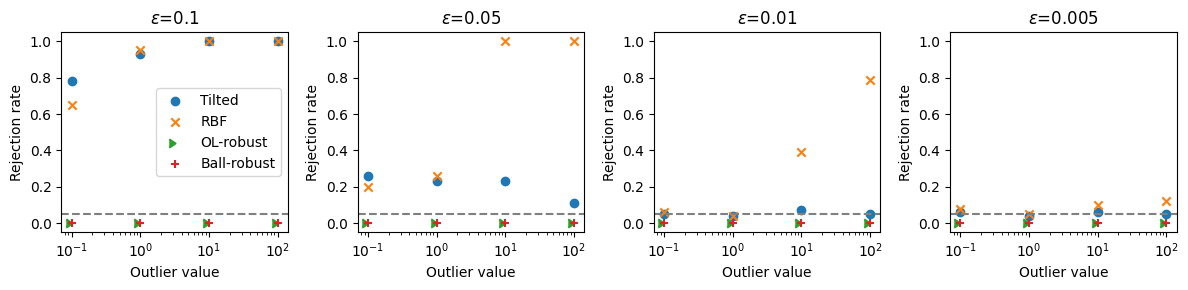

In [118]:
figs, axes = plt.subplots(ncols=len(eps_ls), nrows=1, figsize=(3*len(eps_ls), 3))

# outlier_ls = outlier_ls[::-1]
for j in range(len(eps_ls)):
    ax = axes[j]
    rej_tilted = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["tilted"]["rej"]) for ww in outlier_ls])
    rej_rbf = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["rbf"]["rej"]) for ww in outlier_ls])
    rej_ol_robust = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["tilted_ol_robust"]["rej"]) for ww in outlier_ls])
    rej_ball_robust = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["tilted_ball_robust"]["rej"]) for ww in outlier_ls])

    ax.scatter(outlier_ls, rej_tilted, label="Tilted")
    ax.scatter(outlier_ls, rej_rbf, label="RBF", marker="x")
    ax.scatter(outlier_ls, rej_ol_robust, label="OL-robust", marker=5)
    ax.scatter(outlier_ls, rej_ball_robust, label="Ball-robust", marker="+")
    ax.axhline(0.05, linestyle="--", color="grey")
    ax.set_title(rf"$\epsilon$={eps_ls[j]}")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel("Rejection rate")
    ax.set_xlabel("Outlier value")

axes.flatten()[0].legend()
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ol.pdf")

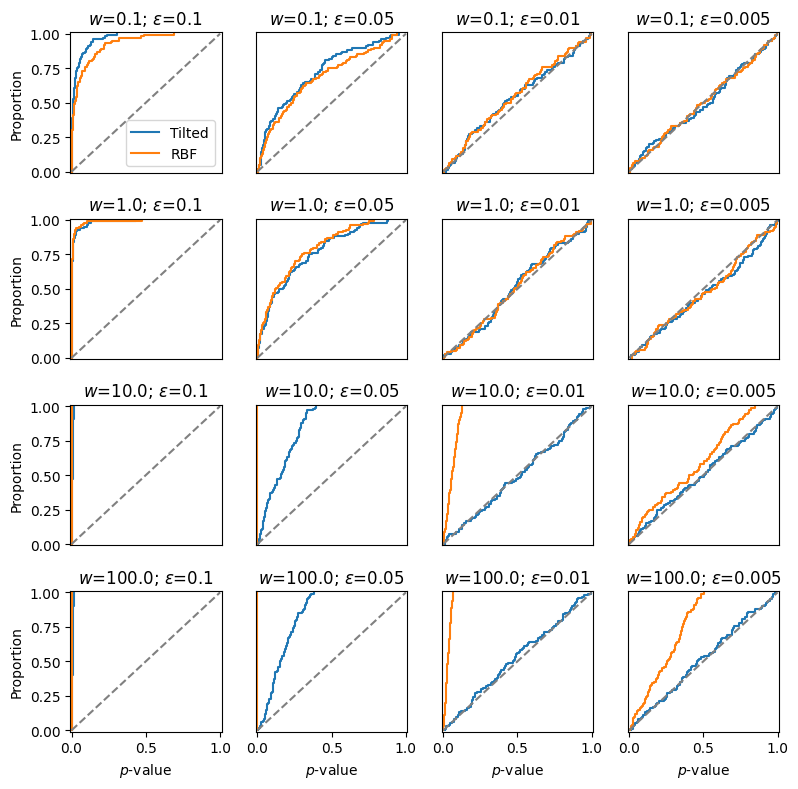

In [45]:
ncols = len(eps_ls)
nrows = len(outlier_ls)
figs, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols, 2*nrows))

# outlier_ls_plot = outlier_ls[::-1]
for i in range(len(outlier_ls_plot)):
    for j in range(len(eps_ls)):
        ax = axes[i][j]
        sns.ecdfplot(ax=ax, x=np.array(res_ol[outlier_ls_plot[i]][n][eps_ls[j]]["tilted"]["pval"]), label="Tilted")
        sns.ecdfplot(ax=ax, x=np.array(res_ol[outlier_ls_plot[i]][n][eps_ls[j]]["rbf"]["pval"]), label="RBF")
        ax.plot([0., 1.], [0., 1.], linestyle="--", color="grey")
        ax.set_xlim(-0.01, 1.01)
        ax.set_ylim(-0.01, 1.01)
        ax.set_title(rf"$w$={outlier_ls_plot[i]}; $\epsilon$={eps_ls[j]}")
        ax.set_ylabel("")
        ax.set_xlabel("")
        
        if i < len(outlier_ls) - 1:
            ax.get_xaxis().set_ticks([])
        if j > 0:
            ax.get_yaxis().set_ticks([])
        if j == 0:
            ax.set_ylabel("Proportion")
        if i == len(outlier_ls) - 1:
            ax.set_xlabel(r"$p$-value")
        # if j == len(eps_ls) - 1:
        #     ax.twinx().set_ylabel(f"eps={eps_ls[j]}")
        #     ax.twinx().get_yaxis().set_ticks([])

axes.flatten()[0].legend(loc="lower right")
plt.tight_layout()

# Level with samples and scores input

In [42]:
np.random.seed(2024)

nreps = 20
n = 500
dim = 1

mean1 = np.zeros((dim,))
mean2 = np.zeros((dim,)) # model

Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nreps, n))

score_fn = lambda x: - (x - mean2)

scores = score_fn(Xs)

hvps = - scores
hvp_denom_sup = 1.

assert scores.shape == Xs.shape

In [ ]:
res = exp_utils.run_tests(
    samples=Xs, 
    scores=scores,
    hvps=hvps,
    hvp_denom_sup=hvp_denom_sup,
    theta=0.1,
    bw="med",
    verbose=True,
)

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 73/100 [00:59<00:20,  1.29it/s]

0.01
0.03
0.0
0.0


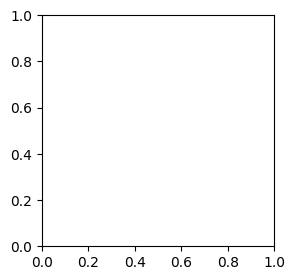

In [46]:
_, ax = plt.subplots(figsize=(3, 3))
methods = ["rbf", "tilted", "tilted_robust_dev", "tilted_robust_clt"]
for m in methods:
    print(np.mean(res[m]["rej"]))

# sns.ecdfplot(ax=ax, x=np.array(res[m]["pval"]))
# ax.plot([0., 1.], [0., 1.], linestyle="--", color="grey")

# Outliers vs. kernel bandwidth (level) 

In [175]:
np.random.seed(2024)

n = 500
eps = 0.01

In [176]:
def ol_standard_ksd(dim, n, eps, nreps, outlier, bw):
    ###
    mean1 = np.zeros((dim,)) # data
    mean2 = np.zeros((dim,)) # model
    
    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nreps, n))
    n_outlier = max(1, int(n * eps))
    Xs[:, :n_outlier] = outlier

    score_fn = lambda x: - (x - mean2)
    ###

    pval_ls = []
    for X in tqdm(Xs):
        kernel = kernels.IMQ(sigma_sq=2. * bw)
        
        ksd = metrics.KSD(kernel, score_fn=score_fn)
        wild_boot = boot.WildBootstrap(ksd)
        pval, _, _ = wild_boot.pval(X, X, return_stat=True, return_boot=True)
        pval_ls.append(pval)

    return pval_ls

In [177]:
outlier_ls = [0., 1., 5., 10., 50.]
bandwidth_ls = [1e-2, 1e-1, 1., 10., 100.]

res_ol_bw = {}
for ol in outlier_ls:
    print("outlier:", ol)
    res_ol_bw[ol] = {}
    
    for bw in bandwidth_ls:
        sub_res_ol = ol_standard_ksd(dim=1, n=n, eps=eps, nreps=100, outlier=ol, bw=bw)
        res_ol_bw[ol][bw] = sub_res_ol

outlier: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

outlier: 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

outlier: 5.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

outlier: 10.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

outlier: 50.0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [188]:
# collect in dataframe
plot_df = {"pval": [], "bw": [], "bw_order": [], "ol": []}
for i, ol in enumerate(outlier_ls):
    for bw in bandwidth_ls:
        rr = res_ol_bw[ol][bw]
        plot_df["pval"].extend(np.array(rr).tolist())
        plot_df["ol"].extend([ol] * len(rr))
        plot_df["bw"].extend([bw] * len(rr))
        plot_df["bw_order"].extend([np.round(np.log(bw) / np.log(10.), 2)] * len(rr))
plot_df = pd.DataFrame(plot_df)
plot_df["rej"] = (plot_df["pval"] <= 0.05).astype(float)

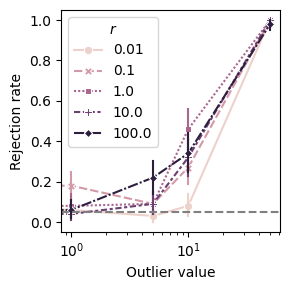

In [189]:
_, ax = plt.subplots(figsize=(3, 3))

_ = sns.lineplot(ax=ax, data=plot_df, x="ol", y="rej", hue="bw_order", style="bw_order", markers=True, err_style="bars")
ax.axhline(0.05, linestyle="--", color="grey")
ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("Outlier value")
ax.set_ylabel("Rejection rate")
sns.move_legend(ax, labels=bandwidth_ls, loc="upper left", title=r"$r$")

plt.tight_layout()
# plt.savefig("../figs/robust/standard_power_bw.pdf")

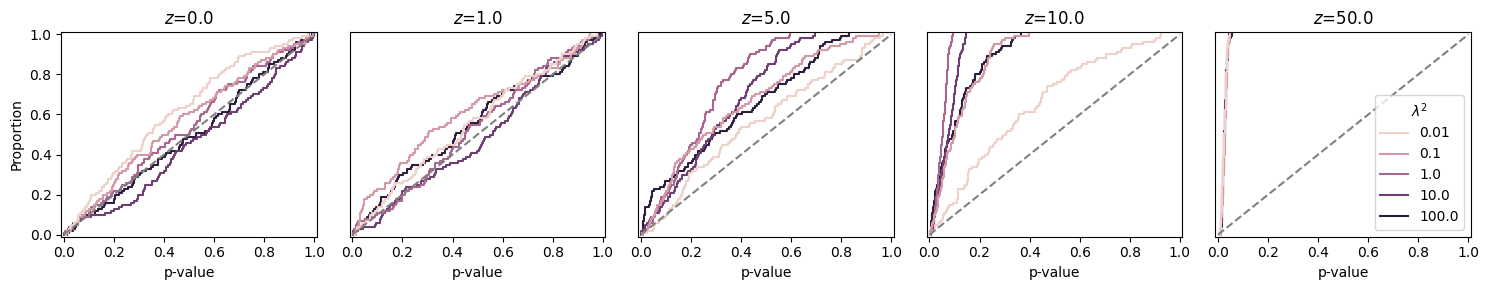

In [220]:
ncols = len(outlier_ls)
figs, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(3*ncols, 3))

method_ls = ["rbf"]

for i, ax in enumerate(axes.flatten()):
    ol = outlier_ls[i]

    plot_df_sub = plot_df.loc[plot_df.ol == ol]
    
    # plot
    if_legend = True if i == len(axes)-1 else False
    ax_init = sns.ecdfplot(ax=ax, data=plot_df_sub, x="pval", hue="bw_order", legend=if_legend)
    ax.plot([0., 1.], [0., 1.], linestyle="--", color="grey")
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    ax.set_title(rf"$z$={ol}")
    ax.set_xlabel("p-value")
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

sns.move_legend(ax, labels=bandwidth_ls, loc="lower right", title=r"$\lambda^2$")
plt.tight_layout()
plt.savefig("../figs/robust/standard_power_bw.pdf")

# Mean-shift (power)

In [352]:
def population_ksd_ms(mean, bandwidth_sq=1.):
    """Non-squared KSD"""
    mu = np.reshape([mean], (-1,))
    d = mu.shape[0]
    mu_norm = np.sqrt(np.sum(mu**2))
    return (bandwidth_sq / (bandwidth_sq + 2))**(d/4) * mu_norm

def inverse_population_ksd_ms(val, dim, bandwidth_sq=1.):
    """val is the non-squared KSD"""
    mu_norm = val * (bandwidth_sq / (bandwidth_sq + 2))**(-dim/4)
    return mu_norm

In [353]:
np.random.seed(2024)

n = 500
n_ls = [n]

mean_ls = [0., 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1., 1.2, 1.4]
# mean_ls = [0., 0.1, 0.15, 0.18, 0.2, 0.25]
mean_ls = [np.reshape([mm], (-1,)) for mm in mean_ls]

eps0 = 0.1 # 0.01

In [354]:
res_ms = exp_utils.rej_rate_meanshift(mean_ls=mean_ls, n_ls=n_ls, eps0=eps0, nreps=50) # auto theta selection
# res_ms = exp_utils.rej_rate_meanshift(mean_ls=mean_ls, n_ls=n_ls, theta=0.1, nreps=20)

key: 0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 1


  0%|          | 0/50 [00:00<?, ?it/s]

key: 2


  0%|          | 0/50 [00:00<?, ?it/s]

key: 3


  0%|          | 0/50 [00:00<?, ?it/s]

key: 4


  0%|          | 0/50 [00:00<?, ?it/s]

key: 5


  0%|          | 0/50 [00:00<?, ?it/s]

key: 6


  0%|          | 0/50 [00:00<?, ?it/s]

key: 7


  0%|          | 0/50 [00:00<?, ?it/s]

key: 8


  0%|          | 0/50 [00:00<?, ?it/s]

key: 9


  0%|          | 0/50 [00:00<?, ?it/s]

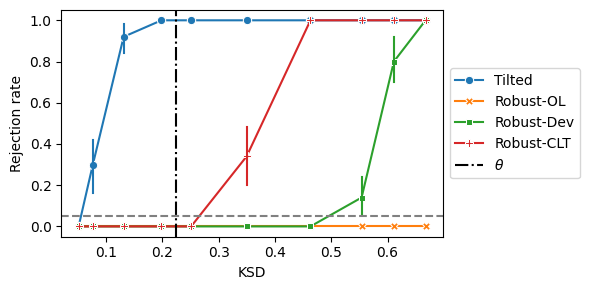

In [359]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

rr = res_ms

methods = {"tilted": "Tilted", "tilted_ol_robust": "Robust-OL", "tilted_robust_dev": "Robust-Dev", "tilted_robust_clt": "Robust-CLT"}

res_df = {"rej": [], "ksd": [], "mean_idx": [], "method": []}
for method, lab in methods.items():
    for kk in range(len(mean_ls)):
        rej = rr[n][kk][method]["rej"]
        res_df["rej"] = res_df["rej"] + rej
        res_df["mean_idx"] = res_df["mean_idx"] + [kk] * len(rej)
        res_df["method"] = res_df["method"] + [lab] * len(rej)
        mean_ksd = np.mean(rr[n][kk][method]["stat"])**0.5
        res_df["ksd"] = res_df["ksd"] + [mean_ksd] * len(rej)
res_df = pd.DataFrame(res_df)

sns.lineplot(ax=ax, data=res_df, x="ksd", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")

theta = rr[n][i]["tilted_robust_dev"]["theta"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

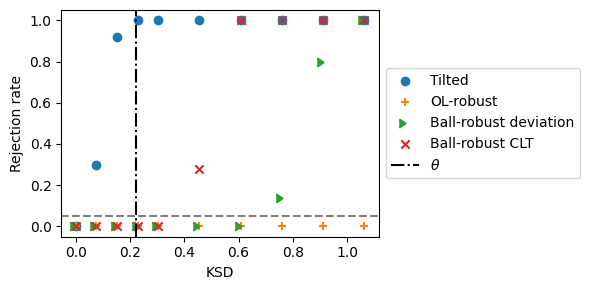

In [205]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

methods = {"tilted": "Tilted", "rbf": "RBF", "tilted_ol_robust": "OL-robust", "tilted_ball_robust": "Ball-robust"}

for method, lab in methods.items():
    rej = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in range(len(mean_ls))])
    ksd = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in range(len(mean_ls))])

rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in range(len(mean_ls))])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in range(len(mean_ls))])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in range(len(mean_ls))])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in range(len(mean_ls))])
rej_ball_clt = np.array([np.mean(res_ms[n][kk]["tilted_ball_clt"]["rej"]) for kk in range(len(mean_ls))])

ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(ksd_ls, rej_tilted, label="Tilted")
# # ax.scatter(ksd_ls, rej_rbf, label="RBF", marker="x")
ax.scatter(ksd_ls, rej_ol_robust, label="OL-robust", marker="+")
ax.scatter(ksd_ls, rej_ball_robust, label="Ball-robust deviation", marker=5)
ax.scatter(ksd_ls, rej_ball_clt, label="Ball-robust CLT", marker="x") #, marker=6)
theta = res_ms[n][0]["tilted_ball_robust"]["theta"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

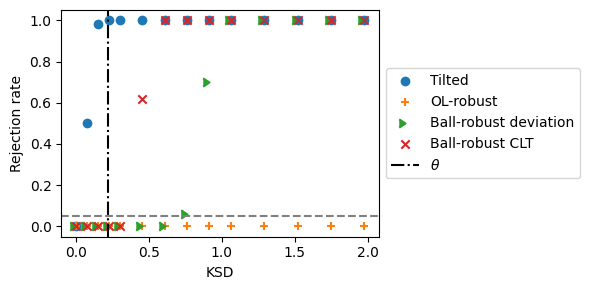

In [170]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

methods = {"tilted": "Tilted", "rbf": "RBF", "tilted_ol_robust": "OL-robust", "tilted_ball_robust": "Ball-robust"}

for method, lab in methods.items():
    rej = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in range(len(mean_ls))])
    ksd = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in range(len(mean_ls))])

rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in range(len(mean_ls))])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in range(len(mean_ls))])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in range(len(mean_ls))])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in range(len(mean_ls))])
rej_ball_clt = np.array([np.mean(res_ms[n][kk]["tilted_ball_clt"]["rej"]) for kk in range(len(mean_ls))])

ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(ksd_ls, rej_tilted, label="Tilted")
# # ax.scatter(ksd_ls, rej_rbf, label="RBF", marker="x")
ax.scatter(ksd_ls, rej_ol_robust, label="OL-robust", marker="+")
ax.scatter(ksd_ls, rej_ball_robust, label="Ball-robust deviation", marker=5)
ax.scatter(ksd_ls, rej_ball_clt, label="Ball-robust CLT", marker="x") #, marker=6)
theta = res_ms[n][0]["tilted_ball_robust"]["theta"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

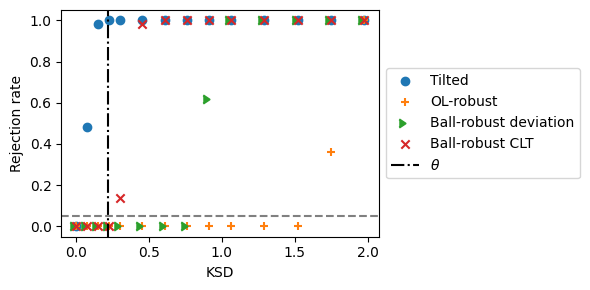

In [38]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

methods = {"tilted": "Tilted", "rbf": "RBF", "tilted_ol_robust": "OL-robust", "tilted_ball_robust": "Ball-robust"}

for method, lab in methods.items():
    rej = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in range(len(mean_ls))])
    ksd = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in range(len(mean_ls))])

rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in range(len(mean_ls))])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in range(len(mean_ls))])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in range(len(mean_ls))])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in range(len(mean_ls))])
rej_ball_clt = np.array([np.mean(res_ms[n][kk]["tilted_ball_clt"]["rej"]) for kk in range(len(mean_ls))])

ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(ksd_ls, rej_tilted, label="Tilted")
# ax.scatter(ksd_ls, rej_rbf, label="RBF", marker="x")
ax.scatter(ksd_ls, rej_ol_robust, label="OL-robust", marker="+")
ax.scatter(ksd_ls, rej_ball_robust, label="Ball-robust deviation", marker=5)
ax.scatter(ksd_ls, rej_ball_clt, label="Ball-robust CLT", marker="x") #, marker=6)
theta = res_ms[n][0]["tilted_ball_robust"]["theta"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

#### Power vs. dim

In [62]:
path = "data/ms"
dim_ls = [1, 100] # [1, 5, 10, 20, 50, 100]
n = 500 # 500

res_ms_dim = {}
for d in dim_ls:
    rr = pickle.load(open("../" + path + f"/ms_stats_n{n}_d{d}.pkl", "rb"))
    res_ms_dim[d] = rr

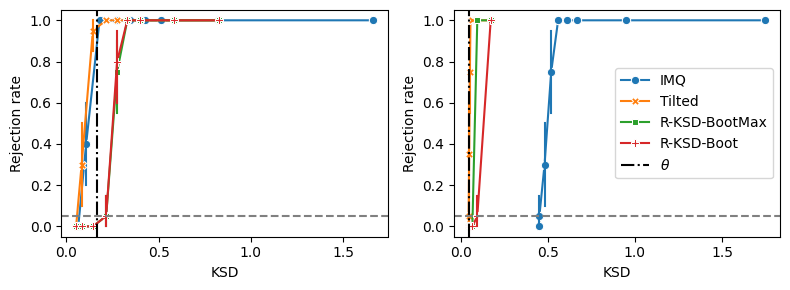

In [68]:
_, axes = plt.subplots(ncols=len(dim_ls), nrows=1, figsize=(4*len(dim_ls), 3))
axes = [axes] if len(dim_ls) == 1 else axes

methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_bootmax": "R-KSD-BootMax", "tilted_r_boot": "R-KSD-Boot"}

for i, ax in enumerate(axes):
    dim = dim_ls[i]
    rr = res_ms_dim[dim]
    
    res_df = {"rej": [], "ksd": [], "mean_idx": [], "method": []}
    for method, lab in methods.items():
        for kk in rr.keys():
            rej = rr[kk][method]["rej"]
            res_df["rej"] = res_df["rej"] + rej
            res_df["mean_idx"] = res_df["mean_idx"] + [kk] * len(rej)
            res_df["method"] = res_df["method"] + [lab] * len(rej)
            mean_ksd = np.mean(rr[kk][method]["stat"])**0.5
            # mean_ksd = np.mean(rr[kk][method]["u_stat"])**0.5
            res_df["ksd"] = res_df["ksd"] + [mean_ksd] * len(rej)
    res_df = pd.DataFrame(res_df)

    sns.lineplot(ax=ax, data=res_df, x="ksd", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")

    theta = rr[kk]["tilted_robust_dev"]["theta"][0]
    ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
    ax.axhline(0.05, linestyle="--", color="grey")
    # ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("KSD")
    ax.set_ylabel("Rejection rate")
    ax.legend([],[], frameon=False)

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.legend()
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

In [11]:
# change theta
theta_new = .3

stats_res_new = copy.deepcopy(stats_res)
for ss in mean_ls:
    stats_res_new[ss] = exp_utils.change_theta(
        stats_res_new[ss], ["tilted_robust_dev", "tilted_robust_clt", "tilted_robust_boot", "tilted_robust_degenboot"], theta_new)

NameError: name 'stats_res' is not defined

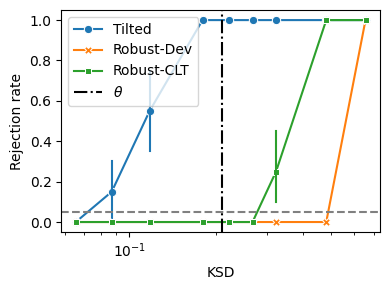

In [430]:
_, axes = plt.subplots(ncols=len(dim_ls), nrows=1, figsize=(4*len(dim_ls), 3))
axes = [axes] if len(dim_ls) == 1 else axes

methods = {"tilted": "Tilted", "tilted_robust_dev": "Robust-Dev", "tilted_robust_clt": "Robust-CLT"}

for i, ax in enumerate(axes):
    dim = dim_ls[i]
    rr = res_ms_dim[dim]

    mean_ls = [np.ones((dim,)) * ss for ss in mean_scale_ls]
    ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
    
    res_df = {"rej": [], "ksd": [], "mean_idx": [], "method": []}
    for method, lab in methods.items():
        for kk in range(len(mean_ls)):
            rej = rr[n][kk][method]["rej"]
            res_df["rej"] = res_df["rej"] + rej
            res_df["mean_idx"] = res_df["mean_idx"] + [kk] * len(rej)
            res_df["method"] = res_df["method"] + [lab] * len(rej)
            mean_ksd = np.mean(rr[n][kk][method]["stat"])**0.5
            res_df["ksd"] = res_df["ksd"] + [mean_ksd] * len(rej)
    res_df = pd.DataFrame(res_df)

    sns.lineplot(ax=ax, data=res_df, x="ksd", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")

    theta = rr[n][i]["tilted_robust_dev"]["theta"][0]
    ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
    ax.axhline(0.05, linestyle="--", color="grey")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("KSD")
    ax.set_ylabel("Rejection rate")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.legend()
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

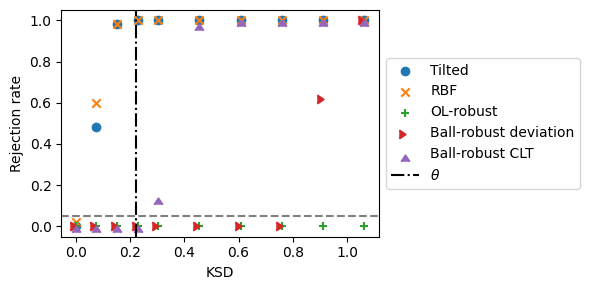

In [295]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

methods = {"tilted": "Tilted", "rbf": "RBF", "tilted_ol_robust": "OL-robust", "tilted_ball_robust": "Ball-robust"}

for method, lab in methods.items():
    rej = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in mean_ls])
    ksd = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in mean_ls])

rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in mean_ls])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in mean_ls])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in mean_ls])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in mean_ls])
rej_ball_clt = np.array([np.mean(res_ms[n][kk]["tilted_ball_clt"]["rej"]) for kk in mean_ls])

ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(ksd_ls, rej_tilted, label="Tilted")
ax.scatter(ksd_ls, rej_rbf, label="RBF", marker="x")
ax.scatter(ksd_ls, rej_ol_robust, label="OL-robust", marker="+")
ax.scatter(ksd_ls, rej_ball_robust, label="Ball-robust deviation", marker=5)
ax.scatter(ksd_ls, rej_ball_clt, label="Ball-robust CLT", marker=6)
theta = res_ms[n][mean_ls[0]]["tilted_ball_robust"]["theta"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

key: 0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


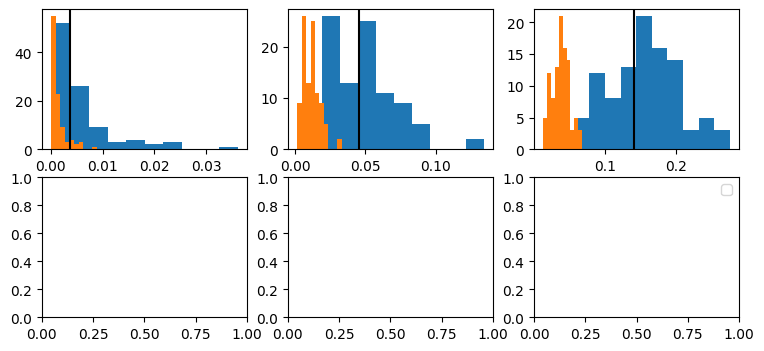

In [171]:
def check_jackknife(mean_ls, n, nreps, dim=1, alpha=0.05):
    res = {kk: {
        "jackknife": [],
        "standard": [],
        "oracle": [],
    } for kk in range(len(mean_ls))}
    res["mean_ls"] = mean_ls
    
    for i, mean in enumerate(mean_ls):
        key = i
        print("key:", key)
        ###
        mean1 = np.zeros((dim,)) # data
        mean2 = np.reshape([mean], (-1,)) # model
        
        Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nreps, n))
    
        score_fn = lambda x: - (x - mean2)
        ###
        
        for X in tqdm(Xs):
            # tilted ball robust CLT
            score_weight_fn = kernels.PolyWeightFunction(loc=mean2)
            kernel0 = kernels.RBF(sigma_sq=2.)
            kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
            ksd = metrics.KSD(kernel, score_fn=score_fn)

            # 1
            res[key]["jackknife"].append(ksd.jackknife(X, X))

            # 2
            u_mat = ksd(X, X, output_dim=2, vstat=True) # n x n
            witness = np.sum(u_mat, axis=1) / n # n
            term1 = np.sum(witness**2) / n
            term2 = (np.mean(u_mat))**2
            res[key]["standard"].append(term1 - term2 + 1e-12)

        # 3. oracle
        # X_ora = np.random.multivariate_normal(mean1, np.eye(dim), (5000,))
        # mm = np.mean(u_mat)
        # res[key]["oracle"] = np.mean((np.sum(u_mat, -1) / n- mm)**2)
        
        Xs_ora = np.random.multivariate_normal(mean1, np.eye(dim), (100, n))
        ksd_val_ls = []
        for X in tqdm(Xs_ora):
            score_weight_fn = kernels.PolyWeightFunction(loc=mean2)
            kernel0 = kernels.RBF(sigma_sq=2.)
            kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
            ksd = metrics.KSD(kernel, score_fn=score_fn)
            ksd_val = ksd(X, X)
            ksd_val_ls.append(ksd_val)
        
        res[key]["oracle"] = np.var(np.sqrt(n) * (ksd_val_ls - np.mean(ksd_val_ls)))
            
    return res


np.random.seed(2024)
mean_ls = [0., 0.2, 0.4]
mean_ls = [np.reshape([mm], (-1,)) for mm in mean_ls]
var_res = check_jackknife(mean_ls=mean_ls, n=n, nreps=100)

_, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 4))
for i in range(len(mean_ls)):
    ax = axes.flatten()[i]
    _ = ax.hist(var_res[i]["jackknife"], label="jackknife")
    _ = ax.hist(var_res[i]["standard"], label="standard")
    ax.axvline(var_res[i]["oracle"], color="k", label="oracle")

plt.legend()

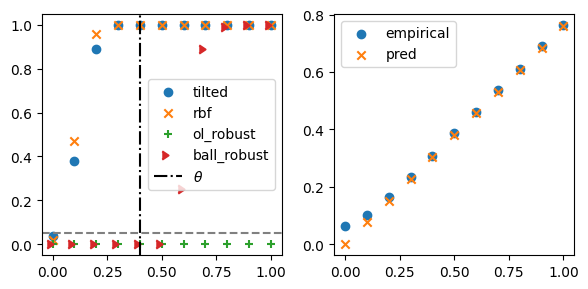

In [111]:
figs, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 3))

ax = axes[0]
rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in mean_ls])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in mean_ls])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in mean_ls])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in mean_ls])

ax.scatter(mean_ls, rej_tilted, label="tilted")
ax.scatter(mean_ls, rej_rbf, label="rbf", marker="x")
ax.scatter(mean_ls, rej_ol_robust, label="ol_robust", marker="+")
ax.scatter(mean_ls, rej_ball_robust, label="ball_robust", marker=5)
theta = res_ms[n][mean_ls[0]]["tilted_ball_robust"]["threshold"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.legend()

ax = axes[1]
ksd_val = [np.mean(res_ms[n][kk]["rbf"]["stat"])**0.5 for kk in mean_ls]
ksd_val_pred = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(mean_ls, ksd_val, label="empirical")
ax.scatter(mean_ls, ksd_val_pred, marker="x", label="pred")
# ax.set_xscale("log")
ax.legend()

plt.tight_layout()

# Degen and non-degen bootstraps

In [387]:
SAVE_DIR = "../data/ms"
n = 200
dim = 1

# X_res = pickle.load(open(f"{SAVE_DIR}/ms_X_res_n{n}_d{dim}.pkl", "rb"))
# score_res = pickle.load(open(f"{SAVE_DIR}/ms_score_res_n{n}_d{dim}.pkl", "rb"))
# hvp_res = pickle.load(open(f"{SAVE_DIR}/ms_hvp_res_n{n}_d{dim}.pkl", "rb"))

In [388]:
np.random.seed(2024)

ss = 1.
mean1 = np.eye(dim)[0, :] * ss
X = np.random.multivariate_normal(mean1, np.eye(dim), (n,)) # nrep, n, 1
score = -X
hvp = -score

# score = score_res[ss][0]
# hvp = hvp_res[ss][0]

In [389]:
hvp_denom_sup = 1
kernel_args = {"sigma_sq": None, "med_heuristic": True, "X": X, "Y": X}

weight_fn_args = {"hvp_denom_sup": hvp_denom_sup}
score_weight_fn = kernels.ScoreWeightFunction(**weight_fn_args)
kernel0 = kernels.RBF(**kernel_args)
kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)

In [390]:
ksd = metrics.KSD(kernel)
bootstrap = boot.WildBootstrap(ksd, ndraws=500)

In [391]:
boot_stats_nondegen, vstat = bootstrap.compute_bootstrap(X, X, score=score, hvp=hvp, degen=False)
boot_stats_degen, _ = bootstrap.compute_bootstrap(X, X, score=score, hvp=hvp, degen=True)

q_nondegen = np.percentile(boot_stats_nondegen - vstat, 100 * 0.95)
q_degen = np.percentile(boot_stats_degen, 100 * 0.95)
print("nondegen", q_nondegen)
print("max", np.max([q_nondegen, q_degen]))

nondegen 0.08145016580820082
max 0.08145016580820082


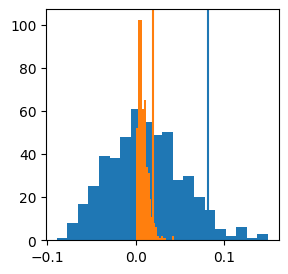

In [394]:
_ = plt.subplots(figsize=(3, 3))
_ = plt.hist(boot_stats_nondegen - vstat, bins=20)
_ = plt.hist(boot_stats_degen, bins=20)

_ = plt.axvline(q_nondegen, color="C0")
_ = plt.axvline(q_degen, color="C1")

# Check whether boot quantile diverges with outlier

In [82]:
np.random.seed(2024)

dim = 1
n = 100 # 200
nreps = 50
ol_mean_ls = [5., 10., 20., 40., 80., 160.] # 40., 80., 160., 1000., 1e4]
eps = 0.05

boot_stats_ls = []
ksd_ls = []
quantiles_ls = []
pvals_ls = []
stein_kernel_val_ls = []
for ol_mean in tqdm(ol_mean_ls):
    ###
    mean1 = np.zeros((dim,)) # data
    mean2 = np.zeros((dim,)) # model
    
    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nreps, n))
    n_outlier = max(1, int(n * eps))
    Xs[:, :n_outlier] = ol_mean

    # X = np.random.multivariate_normal(mean1, np.eye(dim), (n,))
    # n_outlier = max(1, int(n * eps))
    # X[:n_outlier] = ol_mean

    score_fn = lambda x: - (x - mean2)
    ###

    boot_stats_ls.append([])
    ksd_ls.append([])
    quantiles_ls.append([])
    pvals_ls.append([])
    stein_kernel_val_ls.append([])
    for X in Xs:
        # IMQ
        # kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
        kernel = kernels.IMQ(sigma_sq=1.)
        
        ksd = metrics.KSD(kernel, score_fn=score_fn)
        wild_boot = boot.WildBootstrap(ksd)
        pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)

        ksd_ls[-1].append(stat)
        boot_stats_ls[-1].append(boot_stats)
        quantiles_ls[-1].append(np.percentile(boot_stats, 100 * (1 - 0.05)))
        pvals_ls[-1].append(pval)
        stein_kernel_val_ls[-1].append(ksd(jnp.array([[ol_mean]]), jnp.array([[ol_mean]]), vstat=True))

  0%|          | 0/6 [00:00<?, ?it/s]

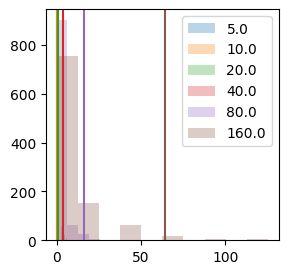

In [83]:
_, ax = plt.subplots(figsize=(3, 3))

for i, ol in enumerate(ol_mean_ls):
    ax.hist(boot_stats_ls[i][0], label=ol, alpha=0.3)
    # sns.ecdfplot(ax=ax, data=boot_stats_ls[i][0], label=ol)
    ax.axvline(x=np.mean(ksd_ls[i]), color=f"C{i}")

ax.legend()
# ax.set_xscale("log")

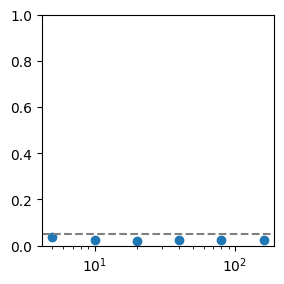

In [84]:
_, ax = plt.subplots(figsize=(3, 3))

ax.scatter(ol_mean_ls, [np.mean(ll) for ll in pvals_ls])
ax.axhline(0.05, color="grey", linestyle="--")
ax.set_ylim(0., 1.)
ax.set_xscale("log")
# ax.set_yscale("log")

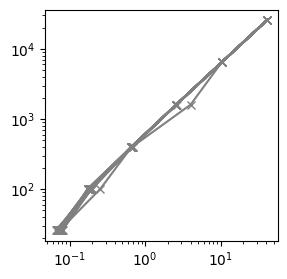

In [91]:
_, ax = plt.subplots(figsize=(3, 3))

_ = ax.plot(quantiles_ls, stein_kernel_val_ls, color="grey", marker="x")
ax.set_xscale("log")
ax.set_yscale("log")

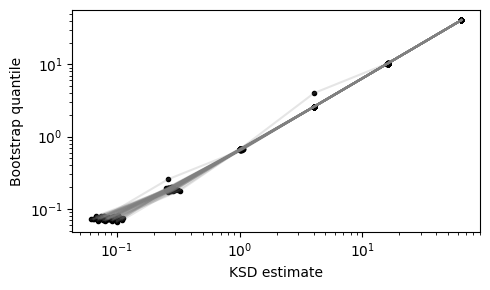

In [128]:
_, ax = plt.subplots(figsize=(5, 3))

# _ = ax.plot(ksd_ls, quantiles_ls, color="grey", marker="x")
_ = ax.plot(ksd_ls, quantiles_ls, color="grey", alpha=0.2)
_ = ax.scatter(ksd_ls, quantiles_ls, color="k", marker=".")

# plot_df = {"ol": [], "ksd": [], "q": []}
# for i, ol in enumerate(ol_mean_ls):
#     plot_df["ol"].extend([ol] * nreps)
#     plot_df["ksd"].extend(np.array(ksd_ls[i]).tolist())
#     plot_df["q"].extend(np.array(quantiles_ls[i]).tolist())
# plot_df = pd.DataFrame(plot_df)
# sns.lineplot(ax=ax, data=plot_df, x="ksd", y="q", markers=True, dashes=False, err_style="bars")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("KSD estimate")
ax.set_ylabel("Bootstrap quantile")
plt.tight_layout()
# plt.savefig("../figs/robust/imqksd_vs_bootquantile.pdf")

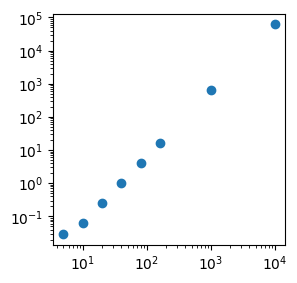

In [55]:
_, ax = plt.subplots(figsize=(3, 3))

ax.scatter(ol_mean_ls, [qq[0] for qq in quantiles_ls])
ax.set_xscale("log")
ax.set_yscale("log")

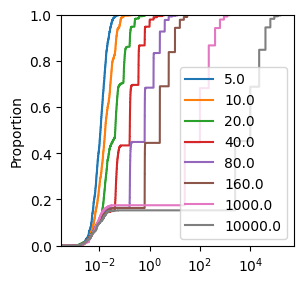

In [56]:
_, ax = plt.subplots(figsize=(3, 3))

for i, ol in enumerate(ol_mean_ls):
    # ax.hist(boot_stats_ls[i], label=ol, alpha=0.3)
    sns.ecdfplot(ax=ax, data=boot_stats_ls[i][0], label=ol)

ax.legend()
ax.set_xscale("log")

(0.0, 1.05)

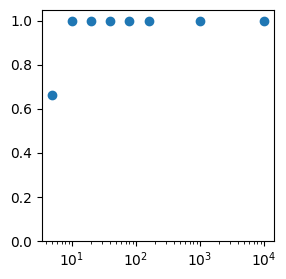

In [57]:
# eps = 0.03
_, ax = plt.subplots(figsize=(3, 3))

rej_ls = []
for i, ol in enumerate(ol_mean_ls):
    rej_ls.append(np.mean([int(s > q) for s, q in zip(ksd_ls[i], quantiles_ls[i])]))

ax.scatter(ol_mean_ls, rej_ls)
ax.set_xscale("log")
ax.set_ylim(0., 1.05)

(0.0, 1.05)

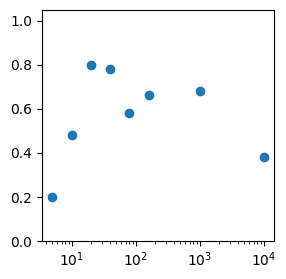

In [53]:
# eps = 0.02
_, ax = plt.subplots(figsize=(3, 3))

rej_ls = []
for i, ol in enumerate(ol_mean_ls):
    rej_ls.append(np.mean([int(s > q) for s, q in zip(ksd_ls[i], quantiles_ls[i])]))

ax.scatter(ol_mean_ls, rej_ls)
ax.set_xscale("log")
ax.set_ylim(0., 1.05)

(0.0, 1.05)

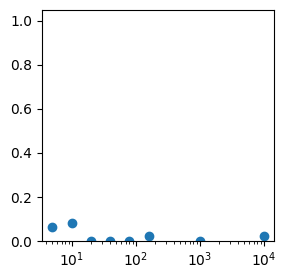

In [49]:
# eps = 0.01
_, ax = plt.subplots(figsize=(3, 3))

rej_ls = []
for i, ol in enumerate(ol_mean_ls):
    rej_ls.append(np.mean([int(s > q) for s, q in zip(ksd_ls[i], quantiles_ls[i])]))

ax.scatter(ol_mean_ls, rej_ls)
ax.set_xscale("log")
ax.set_ylim(0., 1.05)

In [70]:
# growth as a fn of eps
np.random.seed(2024)

dim = 1
n = 100 # 200
nreps = 50
ol_mean = 10.
eps_ls = [0.01, 0.02, 0.03, 0.05, 0.1, 0.15]

boot_stats_ls = []
ksd_ls = []
quantiles_ls = []
pvals_ls = []
stein_kernel_val_ls = []
for eps in tqdm(eps_ls):
    ###
    mean1 = np.zeros((dim,)) # data
    mean2 = np.zeros((dim,)) # model
    
    Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nreps, n))
    n_outlier = max(1, int(n * eps))
    Xs[:, :n_outlier] = ol_mean

    # X = np.random.multivariate_normal(mean1, np.eye(dim), (n,))
    # n_outlier = max(1, int(n * eps))
    # X[:n_outlier] = ol_mean

    score_fn = lambda x: - (x - mean2)
    ###

    boot_stats_ls.append([])
    ksd_ls.append([])
    quantiles_ls.append([])
    pvals_ls.append([])
    stein_kernel_val_ls.append([])
    for X in Xs:
        # IMQ
        # kernel = kernels.IMQ(med_heuristic=True, X=X, Y=X)
        kernel = kernels.IMQ(sigma_sq=1.)
        
        ksd = metrics.KSD(kernel, score_fn=score_fn)
        wild_boot = boot.WildBootstrap(ksd)
        pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)

        ksd_ls[-1].append(stat)
        boot_stats_ls[-1].append(boot_stats)
        quantiles_ls[-1].append(np.percentile(boot_stats, 100 * (1 - 0.05)))
        pvals_ls[-1].append(pval)
        stein_kernel_val_ls[-1].append(eps**2 * ksd(jnp.array([[ol_mean]]), jnp.array([[ol_mean]]), vstat=True))

  0%|          | 0/6 [00:00<?, ?it/s]

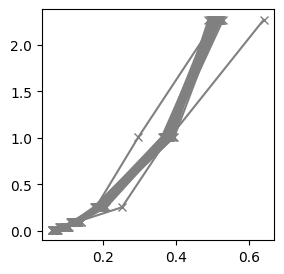

In [74]:
_, ax = plt.subplots(figsize=(3, 3))

_ = ax.plot(quantiles_ls, stein_kernel_val_ls, color="grey", marker="x")
# ax.set_xscale("log")
# ax.set_yscale("log")

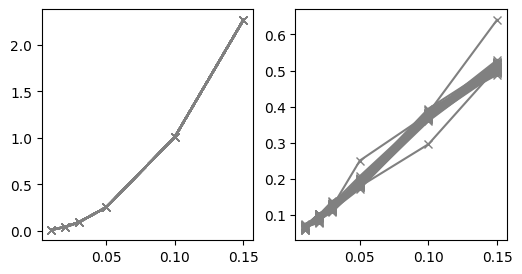

In [76]:
_, axes = plt.subplots(ncols=2, figsize=(6, 3))

ax = axes[0]
_ = ax.plot(eps_ls, stein_kernel_val_ls, color="grey", marker="x")

ax = axes[1]
_ = ax.plot(eps_ls, quantiles_ls, color="grey", marker="x")

# Outlier (level; pre-computed)

In [22]:
n = 500
dim = 1
res_stats_ol = pickle.load(open(f"../data/ol/stats_n{n}_d{dim}.pkl", "rb"))
tau_res = pickle.load(open(f"../data/ol/tau_d{dim}.pkl", "rb"))

In [23]:
ol_ls = list(res_stats_ol.keys())
eps_ls = list(res_stats_ol[ol_ls[0]].keys())

In [24]:
methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD-Boot", "tilted_r_bootmax": "R-KSD-BootMax", 
           "tilted_r_dev": "R-KSD-Dev"}

def convert_df_ol(res_stats_ol):
    res_df = {"rej": [], "ksd": [], "ol": [], "eps": [], "method": [], "theta": []}
    for i, ol in enumerate(ol_ls):
        rr = res_stats_ol[ol]
        
        for eps in eps_ls:
            rr = res_stats_ol[ol][eps]
            for method, lab in methods.items():
                rej = rr[method]["rej"]
                res_df["rej"].extend(rej)
                res_df["ol"].extend([ol] * len(rej))
                res_df["eps"].extend([eps] * len(rej))
                res_df["theta"].extend(rr["tilted_r_bootmax"]["theta"])
                res_df["method"].extend([lab] * len(rej))
                mean_ksd = np.abs(np.mean(rr[method]["u_stat"]))**0.5
                # mean_ksd = np.mean(rr[method]["stat"])**0.5
                res_df["ksd"].extend([mean_ksd] * len(rej))
    res_df = pd.DataFrame(res_df)
    return res_df

In [25]:
res_df = convert_df_ol(res_stats_ol)

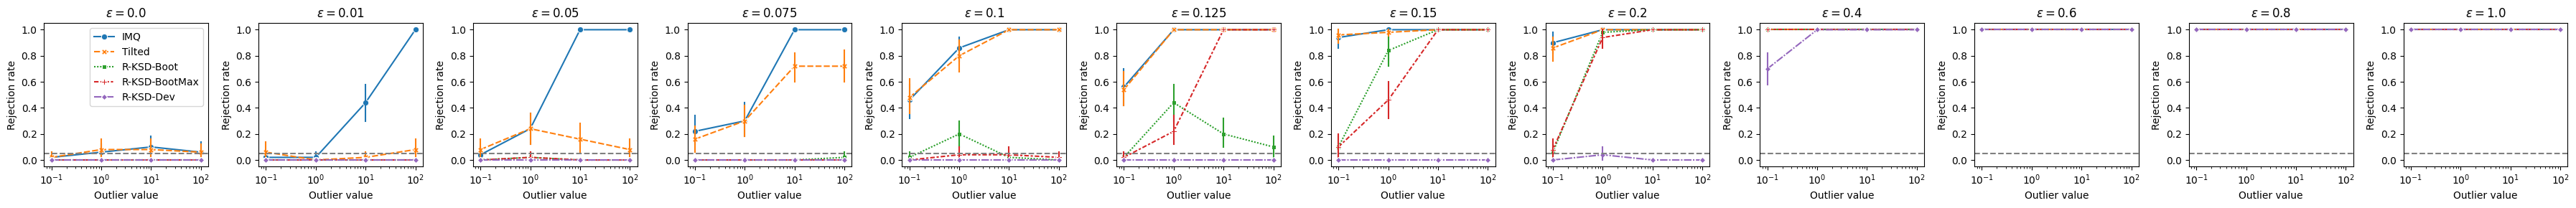

In [26]:
# plot
_, axes = plt.subplots(ncols=len(eps_ls), nrows=1, figsize=(3*len(eps_ls), 3))

for i, eps in enumerate(eps_ls):
    ax = axes[i]
    res_df_sub = res_df.loc[res_df.eps == eps]
    
    sns.lineplot(ax=ax, data=res_df_sub, x="ol", y="rej", hue="method", style="method", markers=True, err_style="bars")

    ax.axhline(0.05, linestyle="--", color="grey")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Outlier value")
    ax.set_ylabel("Rejection rate")
    ax.set_title(rf"$\epsilon={eps}$")
    ax.legend([],[], frameon=False)

# # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
axes[0].legend()
plt.tight_layout()
# # plt.savefig("../figs/robust/rej_ol.pdf")

In [27]:
# change theta
eps0 = 0.05

res_ol_new = copy.deepcopy(res_stats_ol)
for ol in ol_ls:
    for eps in eps_ls:
        # theta_new = eps0 * res_ol_new[ol][eps]["tilted_r_bootmax"]["tau"][0]**0.5
        theta_new = eps0 * tau_res[ol][eps]**0.5
        # theta_new = eps0 * tau_res[0.1][0.]**0.5 #!
        res_ol_new[ol][eps] = exp_utils.change_theta(res_ol_new[ol][eps], ["tilted_r_bootmax", "tilted_r_boot", "tilted_r_dev"], theta_new)

In [38]:
# for ol in ol_ls:
#     for eps in eps_ls:
#         print(ol, "\t", eps, "\t", tau_res[ol][eps])

0.1 	 0.0 	 1.6325634
0.1 	 0.01 	 1.6580245
0.1 	 0.05 	 1.7384338
0.1 	 0.075 	 1.7720177
0.1 	 0.1 	 1.7828219
0.1 	 0.125 	 1.8023423
0.1 	 0.15 	 1.772897
0.1 	 0.2 	 1.8950002
0.1 	 0.4 	 2.1504495
0.1 	 0.6 	 3.1342585
0.1 	 0.8 	 6.586869
0.1 	 1.0 	 11.214314
1.0 	 0.0 	 1.6839375
1.0 	 0.01 	 1.7139328
1.0 	 0.05 	 1.6736107
1.0 	 0.075 	 1.6577129
1.0 	 0.1 	 1.7713041
1.0 	 0.125 	 1.632916
1.0 	 0.15 	 1.630414
1.0 	 0.2 	 1.638344
1.0 	 0.4 	 1.8398124
1.0 	 0.6 	 2.690808
1.0 	 0.8 	 4.8675213
1.0 	 1.0 	 11.840745
10.0 	 0.0 	 1.6522439
10.0 	 0.01 	 1.6328268
10.0 	 0.05 	 1.6040363
10.0 	 0.075 	 1.5866257
10.0 	 0.1 	 1.4467587
10.0 	 0.125 	 1.4115268
10.0 	 0.15 	 1.3828986
10.0 	 0.2 	 1.3616935
10.0 	 0.4 	 1.2274246
10.0 	 0.6 	 1.2609882
10.0 	 0.8 	 4.2673616
10.0 	 1.0 	 12.213194
100.0 	 0.0 	 1.7009223
100.0 	 0.01 	 1.6863225
100.0 	 0.05 	 1.5179354
100.0 	 0.075 	 1.5383273
100.0 	 0.1 	 1.5043604
100.0 	 0.125 	 1.4554427
100.0 	 0.15 	 1.3807397
100.0 

In [39]:
X_res = pickle.load(open(f"../data/ol/X_res_n{n}_d{dim}.pkl", "rb"))

In [49]:
ol = 10.
eps = 1.
Xs = X_res[ol][eps]

In [50]:
score_fn = lambda x: - x # model

X = Xs[0]
score_weight_fn = kernels.PolyWeightFunction()
kernel0 = kernels.IMQ(med_heuristic=True, X=X, Y=X)
kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
ksd = metrics.KSD(kernel, score_fn=score_fn)

opt_res = parallel_optimize(Xs[0, :20], ksd, maxiter=500)
tau = jnp.max(-opt_res)
tau

Array(12.213194, dtype=float32)

In [62]:
kernel0.sigma_sq

Array(0.08187866, dtype=float32)

In [63]:
ksd(X[:5], X[:5], vstat=True, output_dim=2)

Array([[1.1257936 , 0.400964  , 1.1067958 , 1.0355589 , 0.55151445],
       [0.40096405, 1.1427237 , 0.38222355, 0.35987508, 0.7888437 ],
       [1.1067958 , 0.38222355, 1.1248528 , 1.0928962 , 0.5183429 ],
       [1.035559  , 0.3598751 , 1.0928961 , 1.1236296 , 0.47987962],
       [0.55151445, 0.7888437 , 0.518343  , 0.47987965, 1.1364208 ]],      dtype=float32)

In [58]:
xx = np.linspace(-10., 10., 101).reshape((-1, 1))
yy = np.diag(ksd(xx, xx, vstat=True, output_dim=2))

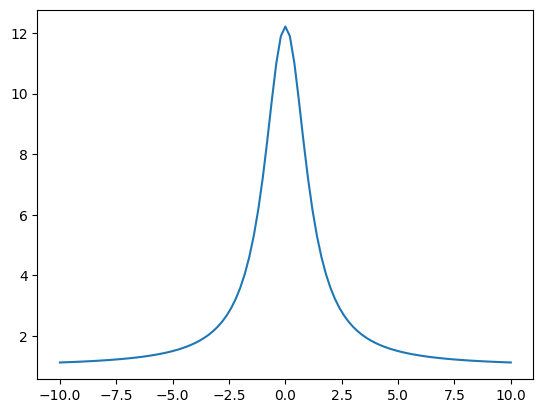

In [60]:
plt.plot(xx[:, 0], yy)

In [10]:
# res_df = convert_df_ol(res_ol_new)
res_df = convert_df_ol(res_stats_ol)

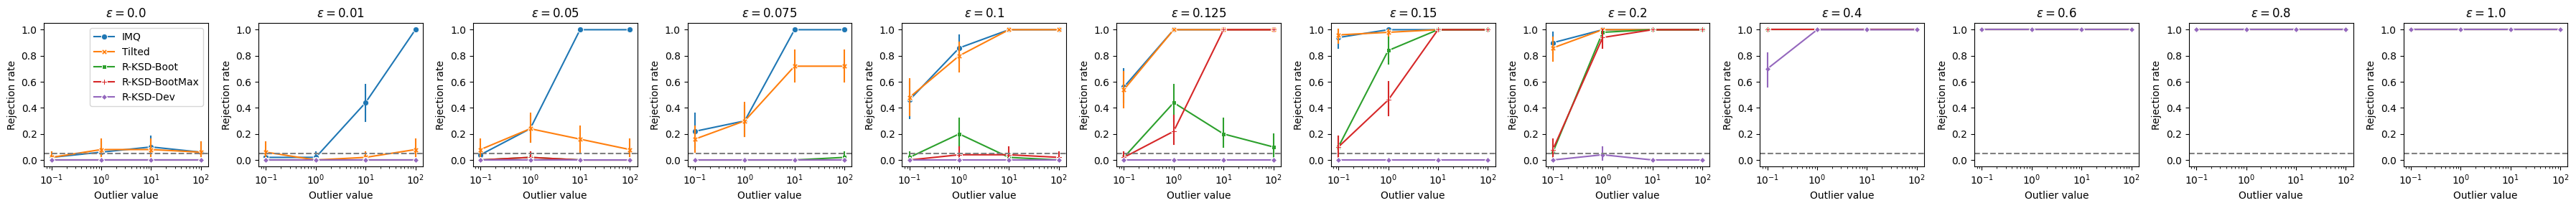

In [11]:
# plot
_, axes = plt.subplots(ncols=len(eps_ls), nrows=1, figsize=(3*len(eps_ls), 3))

for i, eps in enumerate(eps_ls):
    ax = axes[i]
    res_df_sub = res_df.loc[res_df.eps == eps]
    
    sns.lineplot(ax=ax, data=res_df_sub, x="ol", y="rej", hue="method", style="method", markers=True, dashes=False, err_style="bars")

    ax.axhline(0.05, linestyle="--", color="grey")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Outlier value")
    ax.set_ylabel("Rejection rate")
    ax.set_title(rf"$\epsilon={eps}$")
    ax.legend([],[], frameon=False)

# # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
axes[0].legend()
plt.tight_layout()
# # plt.savefig("../figs/robust/rej_ol.pdf")

In [12]:
# X_res = pickle.load(open(f"../data/ol/X_res_n{n}_d{dim}.pkl", "rb"))

ol = 10.
eps = 1 # 0.05
# X = X_res[ol][eps][0]
# _ = plt.hist(X[:, 0])

# res_ol_new[ol][eps]["tilted"]["pval"]

In [13]:
tau_res[ol][eps]**0.5

Array(3.494738, dtype=float32)

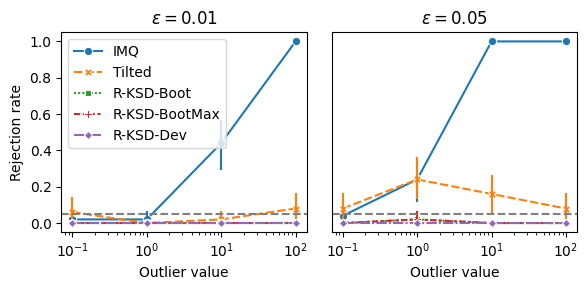

In [65]:
# level plot
eps_ls_plot = [0.01, 0.05]
_, axes = plt.subplots(ncols=len(eps_ls_plot), nrows=1, figsize=(3*len(eps_ls_plot), 3))
# axes = [axes] if len(dim_ls) == 1 else axes

for i, eps in enumerate(eps_ls_plot):
    ax = axes[i]
    res_df_sub = res_df.loc[res_df.eps == eps]
    
    _ = sns.lineplot(ax=ax, data=res_df_sub, x="ol", y="rej", hue="method", style="method", markers=True, err_style="bars")

    ax.axhline(0.05, linestyle="--", color="grey")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Outlier value")
    ax.set_ylabel("Rejection rate")
    ax.set_title(rf"$\epsilon={eps}$")
    ax.legend([],[], frameon=False)
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

# # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
axes[0].legend()
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ol_level.pdf")

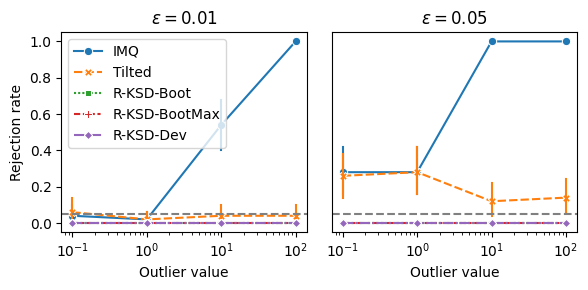

In [12]:
# level plot
eps_ls_plot = [0.01, 0.05]
_, axes = plt.subplots(ncols=len(eps_ls_plot), nrows=1, figsize=(3*len(eps_ls_plot), 3))
# axes = [axes] if len(dim_ls) == 1 else axes

for i, eps in enumerate(eps_ls_plot):
    ax = axes[i]
    res_df_sub = res_df.loc[res_df.eps == eps]
    
    _ = sns.lineplot(ax=ax, data=res_df_sub, x="ol", y="rej", hue="method", style="method", markers=True, err_style="bars")

    ax.axhline(0.05, linestyle="--", color="grey")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Outlier value")
    ax.set_ylabel("Rejection rate")
    ax.set_title(rf"$\epsilon={eps}$")
    ax.legend([],[], frameon=False)
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")
        
# # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
axes[0].legend()
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ol_level.pdf")

In [ ]:
# power plot
eps_ls_plot = [0.1, 0.15, 0.2]
ol_ls_plot = [1., 10., 100.]
_, axes = plt.subplots(ncols=len(ol_ls_plot), nrows=1, figsize=(3*len(eps_ls_plot), 3))
# axes = [axes] if len(dim_ls) == 1 else axes

for i, ol in enumerate(ol_ls_plot):
    ax = axes[i]
    res_df_sub = res_df.loc[(res_df.ol == ol) & (res_df.eps <= 0.5)]
    
    ax.axhline(0.05, linestyle="--", color="grey")
    ax.axvline(eps0, linestyle="-.", color="k")
    _ = sns.lineplot(ax=ax, data=res_df_sub, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars")

    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Contamination ratio")
    ax.set_ylabel("Rejection rate")
    ax.set_title(rf"outlier={ol}")
    ax.legend([],[], frameon=False)
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

plt.tight_layout()
# plt.savefig("../figs/robust/rej_ol_power.pdf")

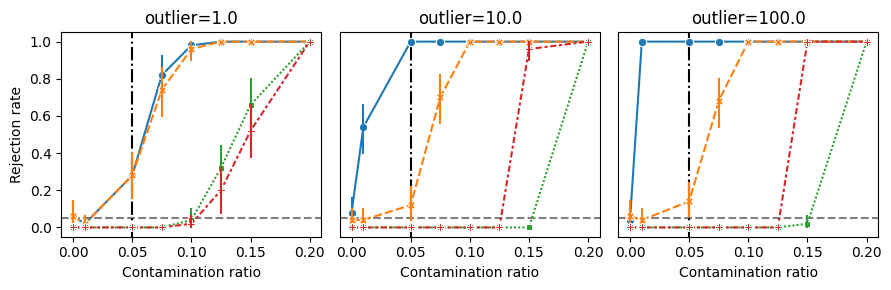

In [22]:
# power plot
eps_ls_plot = [0.1, 0.15, 0.2]
ol_ls_plot = [1., 10., 100.]
_, axes = plt.subplots(ncols=len(ol_ls_plot), nrows=1, figsize=(3*len(eps_ls_plot), 3))
# axes = [axes] if len(dim_ls) == 1 else axes

for i, ol in enumerate(ol_ls_plot):
    ax = axes[i]
    res_df_sub = res_df.loc[res_df.ol == ol]
    
    ax.axhline(0.05, linestyle="--", color="grey")
    ax.axvline(eps0, linestyle="-.", color="k")
    _ = sns.lineplot(ax=ax, data=res_df_sub, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars")

    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Contamination ratio")
    ax.set_ylabel("Rejection rate")
    ax.set_title(rf"outlier={ol}")
    ax.legend([],[], frameon=False)
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

plt.tight_layout()
# plt.savefig("../figs/robust/rej_ol_power.pdf")

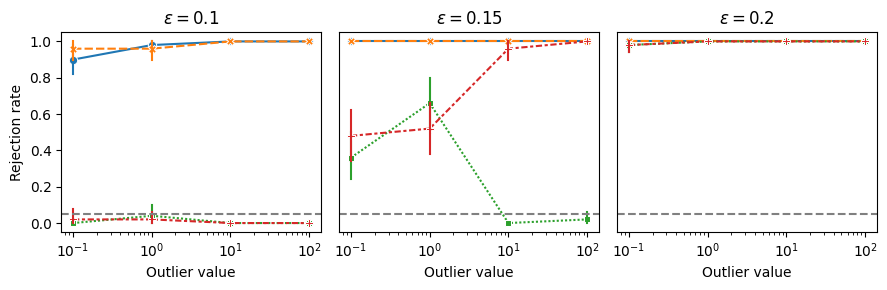

In [21]:
# power plot
eps_ls_plot = [0.1, 0.15, 0.2]
_, axes = plt.subplots(ncols=len(eps_ls_plot), nrows=1, figsize=(3*len(eps_ls_plot), 3))
# axes = [axes] if len(dim_ls) == 1 else axes

for i, eps in enumerate(eps_ls_plot):
    ax = axes[i]
    res_df_sub = res_df.loc[res_df.eps == eps]
    
    _ = sns.lineplot(ax=ax, data=res_df_sub, x="ol", y="rej", hue="method", style="method", markers=True, err_style="bars")

    ax.axhline(0.05, linestyle="--", color="grey")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Outlier value")
    ax.set_ylabel("Rejection rate")
    ax.set_title(rf"$\epsilon={eps}$")
    ax.legend([],[], frameon=False)
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")
        
# # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
# axes[0].legend()
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ol_power.pdf")

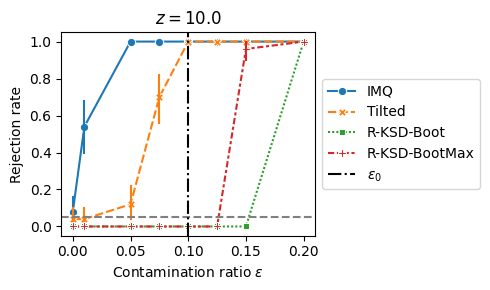

In [22]:
# rej prob vs. contam ratio
_, ax = plt.subplots(figsize=(5, 3))

ol = 10.
res_df_sub = res_df.loc[res_df.ol == ol]

_ = sns.lineplot(ax=ax, data=res_df_sub, x="eps", y="rej", hue="method", style="method", markers=True, err_style="bars")

ax.axhline(0.05, linestyle="--", color="grey")
ax.axvline(theta_new, linestyle="-.", color="k", label=r"$\epsilon_0$")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("Contamination ratio $\epsilon$")
ax.set_ylabel("Rejection rate")
ax.set_title(rf"$z={ol}$")
ax.legend([],[], frameon=False)

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/ucl_ol.pdf")

In [4]:
X_res_ol = pickle.load(open(f"../data/ol/ol_X_res_n{n}_d1.pkl", "rb"))
score_res_ol = pickle.load(open(f"../data/ol/ol_score_res_n{n}_d1.pkl", "rb"))
hvp_res_ol = pickle.load(open(f"../data/ol/ol_hvp_res_n{n}_d1.pkl", "rb"))

In [5]:
X_res_ol_sub = {kk: X_res_ol[kk][0.15] for kk in ol_ls}
score_res_ol_sub = {kk: score_res_ol[kk][0.15] for kk in ol_ls}
hvp_res_ol_sub = {kk: hvp_res_ol[kk][0.15] for kk in ol_ls}

In [6]:
ol_ls

[0.1, 1.0, 10.0, 100.0]

In [7]:
weight_fn_class = kernels.ScoreWeightFunction
base_kernel_class = kernels.IMQ
hvp_denom_sup = 1.
bw = 2. # "med"

i = 0
ol = 10.
X = X_res_ol_sub[ol][i]
score = score_res_ol_sub[ol][i]
hvp = hvp_res_ol_sub[ol][i]

kernel_args = {"sigma_sq": None, "med_heuristic": True, "X": X, "Y": X} if bw == "med" else {"sigma_sq": bw}
score_weight_fn = weight_fn_class(hvp_denom_sup=hvp_denom_sup)
kernel0 = base_kernel_class(**kernel_args)
kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)

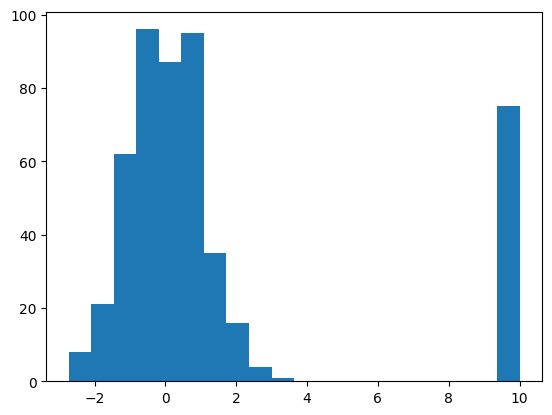

In [8]:
_ = plt.hist(X[:, 0], bins=20)

In [9]:
ksd = metrics.KSD(kernel)
wild_boot = boot.WildBootstrap(ksd)
pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True, score=score, hvp=hvp)
nonsq_stat = stat**0.5
ustat = ksd(X, X, vstat=False, score=score, hvp=hvp)
print("stat", stat)
print("nonsq_stat", nonsq_stat)

stat 0.024314553
nonsq_stat 0.15593125


In [92]:
eps0 = 0.05
theta = "ol"
threshold = ksd.test_threshold(
    n=n, eps0=eps0, theta=theta, alpha=0.05, method="boot", X=X, score=score, hvp=hvp
)
# print("threshold", threshold)

# print("gamma", np.sqrt(threshold - ksd.theta**2))
# print("nonsq threshold", threshold**0.5)

threshold 0.022382826


In [93]:
ksd.theta

Array(0.10606601, dtype=float32)

In [97]:
threshold, pval = ksd.test_threshold(
    n=n, eps0=eps0, theta=theta, alpha=0.05, method="degen_boot", X=X, score=score, 
    hvp=hvp, return_pval=True,
)
# print("gamma", threshold)
# print("gamma + theta", threshold + ksd.theta)
# print("(gamma + theta)**2", (threshold + ksd.theta)**2)

threshold 0.03102796 0.016161421
nonsq threshold 0.17614755


In [ ]:
eps0 = 0.05
theta = "ol"
thresh_res = ksd.test_threshold(
    n=n, eps0=eps0, theta=theta, alpha=0.05, method="boot_both", X=X, score=score, hvp=hvp
)

In [22]:
thresh_res

{'q_max': Array(0.01305861, dtype=float32),
 'q_degen_nonsq': Array(0.08131979, dtype=float32),
 'pval_standard': Array(0.00199601, dtype=float32),
 'vstat': Array(0.02431455, dtype=float32)}

# Mean-shift (power; pre-computed)

In [56]:
SAVE_DIR = "../data/ms"
n = 500
dim = 1

stats_res = pickle.load(open(f"{SAVE_DIR}/stats_n{n}_d{dim}.pkl", "rb"))

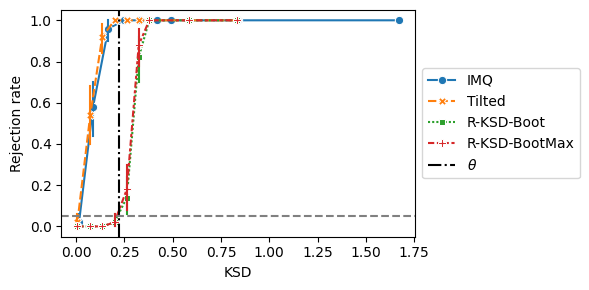

In [57]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

rr = stats_res
mean_ls = list(rr.keys())

methods = {"standard": "IMQ", "tilted": "Tilted", "tilted_r_boot": "R-KSD-Boot", "tilted_r_bootmax": "R-KSD-BootMax"}

res_df = {"rej": [], "ksd": [], "mean_idx": [], "method": []}
for method, lab in methods.items():
    for kk, ss in enumerate(mean_ls):
        rej = rr[ss][method]["rej"]
        res_df["rej"] = res_df["rej"] + rej
        res_df["mean_idx"] = res_df["mean_idx"] + [kk] * len(rej)
        res_df["method"] = res_df["method"] + [lab] * len(rej)
        mean_ksd = np.abs(np.mean(rr[ss][method]["u_stat"]))**0.5
        res_df["ksd"] = res_df["ksd"] + [mean_ksd] * len(rej)
res_df = pd.DataFrame(res_df)
            
sns.lineplot(ax=ax, data=res_df, x="ksd", y="rej", hue="method", style="method", markers=True, err_style="bars")

theta = rr[mean_ls[0]]["theta"]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

In [58]:
# # check level
# imqksd_pvals = rr[0.01]["standard"]["pval"]
# np.mean(np.array(imqksd_pvals) < 0.05)

In [59]:
stats_res[0.01].keys()

dict_keys(['standard', 'tilted', 'tilted_r_boot', 'tilted_r_bootmax', 'tilted_r_dev', 'theta'])

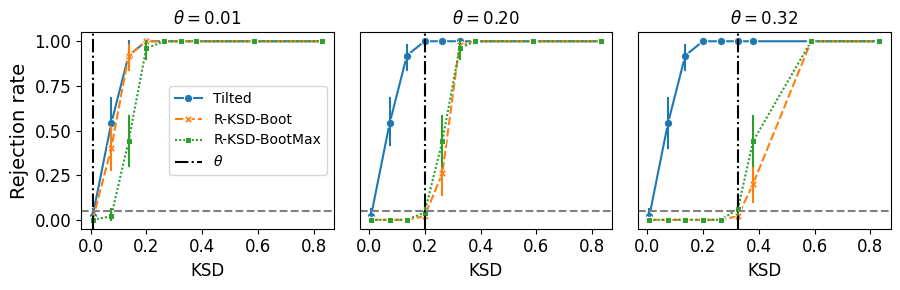

In [62]:
theta_new_ls = [
    res_df.loc[(res_df.method == "Tilted") & (res_df.mean_idx == 0), "ksd"].mean(),
    res_df.loc[(res_df.method == "Tilted") & (res_df.mean_idx == 3), "ksd"].mean(),
    res_df.loc[(res_df.method == "Tilted") & (res_df.mean_idx == 5), "ksd"].mean(),
]

_, axes = plt.subplots(ncols=3, nrows=1, figsize=(3*len(theta_new_ls), 3))

for i, theta_new in enumerate(theta_new_ls):
    # change theta
    stats_res_new = copy.deepcopy(stats_res)
    for ss in mean_ls:
        stats_res_new[ss] = exp_utils.change_theta(
            stats_res_new[ss], ["tilted_r_bootmax", "tilted_r_boot"], theta_new)

    # plot
    rr = stats_res_new
    mean_ls = list(rr.keys())
    
    methods = {"tilted": "Tilted", "tilted_r_boot": "R-KSD-Boot", "tilted_r_bootmax": "R-KSD-BootMax"}
    
    res_df = {"rej": [], "ksd": [], "mean_idx": [], "method": []}
    for method, lab in methods.items():
        for kk, ss in enumerate(mean_ls):
            rej = rr[ss][method]["rej"]
            res_df["rej"] = res_df["rej"] + rej
            res_df["mean_idx"] = res_df["mean_idx"] + [kk] * len(rej)
            res_df["method"] = res_df["method"] + [lab] * len(rej)
            mean_ksd = np.abs(np.mean(rr[ss][method]["u_stat"]))**0.5
            res_df["ksd"] = res_df["ksd"] + [mean_ksd] * len(rej)
    res_df = pd.DataFrame(res_df)

    ax = axes[i]
    sns.lineplot(ax=ax, data=res_df, x="ksd", y="rej", hue="method", style="method", markers=True, err_style="bars")
    
    theta = rr[mean_ls[0]]["theta"]
    ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
    ax.axhline(0.05, linestyle="--", color="grey")
    # ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("KSD", fontsize=12)
    ax.set_ylabel("Rejection rate", fontsize=14)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(r"$\theta=${:.2f}".format(round(theta, 2)))
    ax.legend([],[], frameon=False)

    if i == 0:
        ax.legend()
    else:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")
        
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

In [53]:
SAVE_DIR = "../data/ms"
n = 500
dim_ls = [10, 50, 100]

stats_res_ls = {}
for dim in dim_ls:
    stats_res_ls[dim] = pickle.load(open(f"{SAVE_DIR}/stats_n{n}_d{dim}.pkl", "rb"))

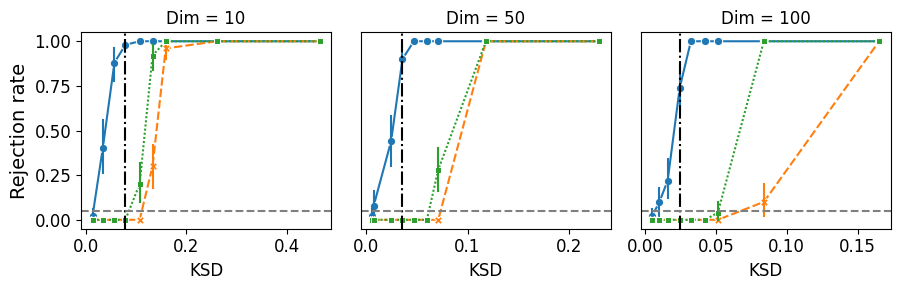

In [55]:
_, axes = plt.subplots(ncols=len(dim_ls), nrows=1, figsize=(3*len(dim_ls), 3))

for i, dim in enumerate(dim_ls):
    
    rr = stats_res_ls[dim]
    mean_ls = list(rr.keys())
    
    methods = {"tilted": "Tilted", "tilted_r_boot": "R-KSD-Boot", "tilted_r_bootmax": "R-KSD-BootMax"}
    
    res_df = {"rej": [], "ksd": [], "mean_idx": [], "method": []}
    for method, lab in methods.items():
        for kk, ss in enumerate(mean_ls):
            rej = rr[ss][method]["rej"]
            res_df["rej"] = res_df["rej"] + rej
            res_df["mean_idx"] = res_df["mean_idx"] + [kk] * len(rej)
            res_df["method"] = res_df["method"] + [lab] * len(rej)
            mean_ksd = np.abs(np.mean(rr[ss][method]["u_stat"]))**0.5
            res_df["ksd"] = res_df["ksd"] + [mean_ksd] * len(rej)
    res_df = pd.DataFrame(res_df)

    # change theta
    theta_new = res_df.loc[(res_df.method == "Tilted") & (res_df.mean_idx == 3), "ksd"].mean()
    stats_res_new = copy.deepcopy(rr)
    for ss in mean_ls:
        stats_res_new[ss] = exp_utils.change_theta(stats_res_new[ss], ["tilted_r_bootmax", "tilted_r_boot"], theta_new)

    # plot
    ax = axes[i]
    sns.lineplot(ax=ax, data=res_df, x="ksd", y="rej", hue="method", style="method", markers=True, err_style="bars")
    
    ax.axvline(theta_new, linestyle="-.", color="k", label=r"$\theta$")
    ax.axhline(0.05, linestyle="--", color="grey")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("KSD", fontsize=12)
    ax.set_ylabel("Rejection rate", fontsize=14)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(f"Dim = {dim}")
    ax.legend([],[], frameon=False)

    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms_dim.pdf")

# Front page figure

In [25]:
# dim = 1
# n = 500
# nreps = 100
# ol_mean = np.eye(dim)[0] * 10.
# eps_ls = [0., 0.05]

# Xs_ls = []
# val_ls_imq = []
# val_ls_tilted = []
# pval_ls_imq = []
# pval_ls_tilted = []
# pval_ls_boot = []
# pval_ls_bootmax = []
# for eps in eps_ls:
#     np.random.seed(54321)
    
#     ###
#     mean1 = np.zeros((dim,)) # data
#     mean2 = np.zeros((dim,)) # model
    
#     Xs = jnp.array(np.random.normal(mean1, size=(nreps, n, dim)))
#     Xs = jax.vmap(lambda x: exp_efm.sample_outlier_contam(x, eps, ol_mean, 0.1))(Xs)

#     Xs_ls.append(Xs)
    
#     score_fn = lambda x: - (x - mean2)
#     ###

#     score = score_fn(Xs)
#     hvp = - score

#     # # find oracle theta
#     # score_weight_fn = kernels.PolyWeightFunction()
#     # kernel0 = kernels.IMQ(med_heuristic=True, X=Xs[0], Y=Xs[0])
#     # kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)

#     # ksd = metrics.KSD(kernel)
#     # xx = jnp.linspace(10., 20., 10001)
#     # xx = jnp.reshape(xx, (-1, 1))
#     # ss = jax.vmap(score_fn)(xx)
#     # idx = jnp.arange(xx.shape[0])
#     # ksd_vals = jax.vmap(lambda i: exp_kef.compute_ksd(xx[i], ss[i], ksd))(idx)
#     # tau = jnp.max(ksd_vals)
#     # theta = 0.05 * tau**0.5

#     hvp_denom_sup = 1.
#     res = exp_utils.run_tests(
#         samples=Xs, scores=score, hvps=hvp, hvp_denom_sup=hvp_denom_sup, 
#         theta="ol", eps0=0.1,
#         # theta=theta,
#         bw="med", alpha=0.05, verbose=True,
#     )
#     pval_ls_imq.append(res["standard"]["pval"])
#     pval_ls_tilted.append(res["tilted"]["pval"])
#     pval_ls_boot.append(res["tilted_r_boot"]["pval"])
#     # pval_ls_bootmax.append(res["tilted_r_bootmax"]["pval"])

#     val_ls_imq.append(res["standard"]["nonsq_stat"])
#     val_ls_tilted.append(res["tilted"]["nonsq_stat"])

In [7]:
dim = 1
n = 500
ol = 10.
eps_ls = [0., 0.05]

res_stats= pickle.load(open(f"../data/ol/ol_stats_n{n}_d1.pkl", "rb"))

Xs_ls = []
val_ls_imq = []
val_ls_tilted = []
rej_ls_imq = []
rej_ls_tilted = []
rej_ls_boot = []
rej_ls_bootmax = []
for eps in eps_ls:
    res = res_stats[ol][eps]
    
    rej_ls_imq.append(res["standard"]["rej"])
    rej_ls_tilted.append(res["tilted"]["rej"])
    rej_ls_boot.append(res["tilted_r_boot"]["rej"])
    rej_ls_bootmax.append(res["tilted_r_bootmax"]["rej"])

    val_ls_imq.append(res["standard"]["nonsq_stat"])
    val_ls_tilted.append(res["tilted"]["nonsq_stat"])

nreps = len(res["standard"]["rej"])

In [8]:
X_res = pickle.load(open(f"../data/ol/ol_X_res_n{n}_d1.pkl", "rb"))
Xs_ls = [X_res[ol][eps_ls[0]], X_res[ol][eps_ls[1]]]

In [ ]:
from pylab import setp
import matplotlib


# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    c1, c2 = "C0", "C1"
    setp(bp['boxes'][0], color=c1, linewidth=2)
    setp(bp['caps'][0], color=c1, linewidth=2)
    setp(bp['caps'][1], color=c1, linewidth=2)
    setp(bp['whiskers'][0], color=c1, linewidth=2)
    setp(bp['whiskers'][1], color=c1, linewidth=2)
    # setp(bp['fliers'][0], color=c1)
    # setp(bp['fliers'][1], color=c1)
    setp(bp['medians'][0], color=c1, linewidth=2)

    setp(bp['boxes'][1], color=c2, linewidth=2)
    setp(bp['caps'][2], color=c2, linewidth=2)
    setp(bp['caps'][3], color=c2, linewidth=2)
    setp(bp['whiskers'][2], color=c2, linewidth=2)
    setp(bp['whiskers'][3], color=c2, linewidth=2)
    setp(bp['medians'][1], color=c2, linewidth=2)

_, axes = plt.subplots(ncols=2, figsize=(10, 3))

# bins = np.histogram(np.hstack(
#     (Xs_ls[0][0].reshape(-1), Xs_ls[1].reshape(-1))
# ), bins=25)[1]

xvals = jnp.linspace(-3., ol_mean+1., 1001)
norm_den = jax.scipy.stats.norm.pdf(xvals)

# hist plots
ax = axes[0]
_, bins, patches = ax.hist(Xs_ls[1][0].reshape(-1), bins, color="grey", density=True, linewidth=1.5)
patches[-1].set(edgecolor="C1", linewidth=1.5, label="Outlier")
ax.hist(Xs_ls[0][0].reshape(-1), bins, color="grey", density=True, edgecolor="grey", linewidth=1.5, label="Data")
ax.get_yaxis().set_visible(False)

ax.plot(xvals, norm_den, linewidth=3, label=r"Model $P$", color="C0")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()

# boxplots
ax = axes[1]
df = pd.DataFrame({
    "rej": np.concatenate(rej_ls_imq + rej_ls_tilted + rej_ls_boot + rej_ls_bootmax, 0).tolist(),
    "method": ["IMQ"] * nreps * 2 + ["Tilted"] * nreps * 2 + ["R-KSD-Boot"] * nreps * 2 + ["R-KSD-BootMax"] * nreps * 2,
    "Outlier": ["Without"] * nreps + ["With"] * nreps + ["Without"] * nreps + ["With"] * nreps + ["Without"] * nreps + ["With"] * nreps + ["Without"] * nreps + ["With"] * nreps,
})
b = sns.barplot(data=df, x="method", y="rej", hue="Outlier", errorbar=None)
h3 = ax.axhline(0.05, color="grey", linestyle="--")
ax.set_ylim(0, 1.1)
ax.set_xlabel("")
plt.xticks(fontsize=10)
ax.set_ylabel("Rejection probability", fontsize=13)
patches = [matplotlib.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(t.get_text() for t in b.get_xticklabels())]
ax.legend(handles=patches[:2]+[h3], labels=["Without outliers", "With outliers", r"$\alpha=0.05$"])
for container in b.containers:
    b.bar_label(container)

plt.tight_layout()
# plt.savefig("../figs/robust/thumbnail.pdf")

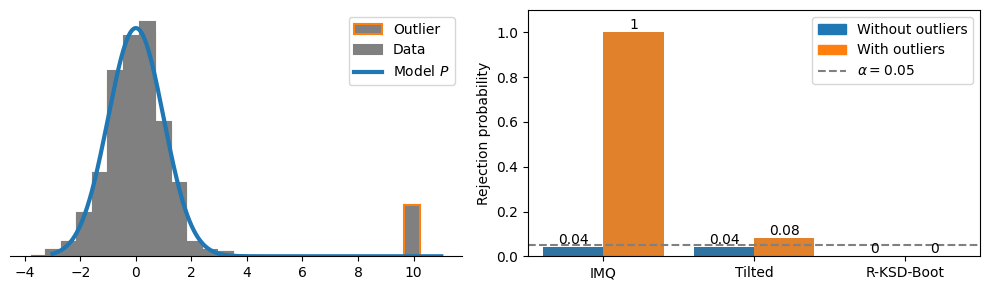

In [98]:
from pylab import setp
import matplotlib


# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    c1, c2 = "C0", "C1"
    setp(bp['boxes'][0], color=c1, linewidth=2)
    setp(bp['caps'][0], color=c1, linewidth=2)
    setp(bp['caps'][1], color=c1, linewidth=2)
    setp(bp['whiskers'][0], color=c1, linewidth=2)
    setp(bp['whiskers'][1], color=c1, linewidth=2)
    # setp(bp['fliers'][0], color=c1)
    # setp(bp['fliers'][1], color=c1)
    setp(bp['medians'][0], color=c1, linewidth=2)

    setp(bp['boxes'][1], color=c2, linewidth=2)
    setp(bp['caps'][2], color=c2, linewidth=2)
    setp(bp['caps'][3], color=c2, linewidth=2)
    setp(bp['whiskers'][2], color=c2, linewidth=2)
    setp(bp['whiskers'][3], color=c2, linewidth=2)
    setp(bp['medians'][1], color=c2, linewidth=2)

_, axes = plt.subplots(ncols=2, figsize=(10, 3))

bins = np.histogram(np.hstack(
    (Xs_ls[0][0].reshape(-1), Xs_ls[1].reshape(-1))
), bins=25)[1]

xvals = jnp.linspace(-3., ol_mean+1., 1001)
norm_den = jax.scipy.stats.norm.pdf(xvals)

# hist plots
ax = axes[0]
ax.hist(Xs_ls[1][0].reshape(-1), bins, color="grey", density=True, edgecolor="C1", linewidth=1.5, label="Outlier")
ax.hist(Xs_ls[0][0].reshape(-1), bins, color="grey", density=True, edgecolor="grey", linewidth=1.5, label="Data")
ax.get_yaxis().set_visible(False)

ax.plot(xvals, norm_den, linewidth=3, label=r"Model $P$", color="C0")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()

# boxplots
ax = axes[1]
# df = pd.DataFrame({
#     "rej": (np.concatenate(pval_ls_imq + pval_ls_tilted, 0) < 0.05).tolist(),
#     "method": ["IMQ"] * nreps * 2 + ["Tilted"] * nreps * 2,
#     "Outlier": ["Without"] * nreps + ["With"] * nreps + ["Without"] * nreps + ["With"] * nreps,
# })
df = pd.DataFrame({
    "rej": (np.concatenate(pval_ls_imq + pval_ls_tilted + pval_ls_boot, 0) < 0.05).tolist(),
    "method": ["IMQ"] * nreps * 2 + ["Tilted"] * nreps * 2 + ["R-KSD-Boot"] * nreps * 2,
    "Outlier": ["Without"] * nreps + ["With"] * nreps + ["Without"] * nreps + ["With"] * nreps + ["Without"] * nreps + ["With"] * nreps,
})
b = sns.barplot(data=df, x="method", y="rej", hue="Outlier", errorbar=None)
h3 = ax.axhline(0.05, color="grey", linestyle="--")
ax.set_ylim(0, 1.1)
ax.set_xlabel("")
ax.set_ylabel("Rejection probability")
patches = [matplotlib.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(t.get_text() for t in b.get_xticklabels())]
ax.legend(handles=patches[:2]+[h3], labels=["Without outliers", "With outliers", r"$\alpha=0.05$"])
for container in b.containers:
    b.bar_label(container)

plt.tight_layout()
# plt.savefig("../figs/robust/thumbnail.pdf")

\begin{tabular}{lrr}
\toprule
 & IMQ & Tilted \\
\midrule
Without & 0.6 & 0.47 \\
With & 0.045 & 0.47 \\
\bottomrule
\end{tabular}



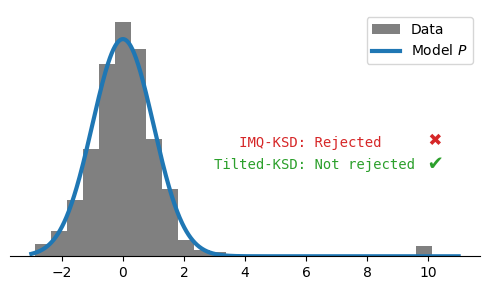

In [8]:
_, ax = plt.subplots(figsize=(5, 3))

bins = np.histogram(np.hstack(
    (X_ls[0].reshape(-1), X_ls[1].reshape(-1))
), bins=25)[1]

xvals = jnp.linspace(-3., ol_mean+1., 1001)
norm_den = jax.scipy.stats.norm.pdf(xvals)

t_ls = [
    "   IMQ-KSD: ",
    "Tilted-KSD: "
]
checks_ls = []
outlier_pvals = [pval_ls_imq[1], pval_ls_boot[1]]
for i, pval in enumerate(outlier_pvals):
    suffix = "Rejected" if pval < 0.05 else "Not rejected"
    t_ls[i] += suffix
    checks_ls.append("\u2716" if pval < 0.05 else "\u2714")

pvals_df = pd.DataFrame({"IMQ": pval_ls_imq, "Tilted": pval_ls_tilted}, index=["Without", "With"])

ax.hist(X_ls[1].reshape(-1), bins, color="grey", density=True)
ax.hist(X_ls[0].reshape(-1), bins, color="grey", density=True, label="Data")
ax.get_yaxis().set_visible(False)

ax.plot(xvals, norm_den, linewidth=3, label=r"Model $P$")

ax.text(3., .2, t_ls[0], fontname="monospace", color="C3")
ax.text(3., .16, t_ls[1], fontname="monospace", color="C2")

ax.text(10., .2, checks_ls[0], fontname="monospace", color="C3", fontsize=16)
ax.text(10., .16, checks_ls[1], fontname="monospace", color="C2", fontsize=16)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.legend()

plt.tight_layout()
# plt.savefig("../figs/robust/front_fig.pdf")

print(pvals_df.to_latex(float_format="{:.2g}".format,))

In [72]:
# var decomp of v stats
def sum_coeffs(n):
    return n*(n-1)*(n-2)*(n-3) + 2*n*(n-1)*(n-2) + 4*n*(n-1)*(n-2) + n*(n-1) + 2*n*(n-1) + 4*n*(n-1) + n

In [74]:
nn = 4
sum_coeffs(nn), nn**4

(256, 256)

# Plot for Stein kernels

In [4]:
X = jnp.reshape(jnp.linspace(-3., 3., 1001), (-1, 1))

b_ls = [0., 0.25, 0.5, 1.]
ksd_vals_ls = []

score_fn = lambda x: -x

# IMQ
kernel = kernels.IMQ(sigma_sq=2*1.)
ksd_imq = metrics.KSD(kernel, score_fn=score_fn)

ksd_imq_vals = np.diagonal(ksd_imq(X, X, vstat=True, output_dim=2))
ksd_vals_ls.append(ksd_imq_vals)

# R-KSD boot
score = score_fn(X)
hvp = - score

for b in b_ls[1:]:
    score_weight_fn = kernels.PolyWeightFunction(b=b)
    kernel0 = kernels.IMQ(sigma_sq=2*1.)
    kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    ksd_tilted = metrics.KSD(kernel)
    
    ksd_tilted_vals = np.diagonal(ksd_tilted(X, X, vstat=True, output_dim=2, score=score, hvp=hvp))
    ksd_vals_ls.append(ksd_tilted_vals)

2.75
4.0
9.0


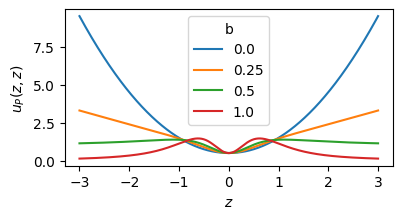

In [9]:
# import matplotlib as mpl
# mpl.rcParams['text.usetex'] = True

_, ax = plt.subplots(figsize=(4, 2.3))
linestyles = ["solid", "dotted", "dashed", "dashdot"]

for i, b in enumerate(b_ls):
    ksd_vals = ksd_vals_ls[i]
    # ax.plot(np.reshape(X, -1), ksd_vals, label=f"b={b}", linestyle=linestyles[i])
    ax.plot(np.reshape(X, -1), ksd_vals, label=f"{b}")
# ax.set_yscale("log")
ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$u_P(z, z)$")
# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.legend(title="b")
plt.tight_layout()
plt.savefig("../figs/robust/stein_kernels.pdf")